# Evaluación de gastos de una aseguradora
### Información del autor
- Martín Michael De Lojo
- martinmdl42@gmail.com
- Matemática 3
- Tecnicatura en Programación Informática
- Universidad de San Martín
- Primer cuatrimestre del 2023

### Información del analisis
- Base de datos: [insurance.csv](https://drive.google.com/file/d/1bCzitIg0ETu1hMjd_MbNnncxleH6hrhH/view?usp=sharing)
- **Objetivo:** estimar el gasto que le generará una persona a la aseguradora.

In [990]:
# modulos que voy a usar
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

#### DataFrame

In [991]:
# leo el archivo con datos previos
df = pd.read_csv('insurance.csv', low_memory=False)

# desempaqueto el atributo "shape"
df_filas, df_columnas = df.shape
print(f"TOTAL: {df_filas} filas x {df_columnas} columnas")

# cambio los nombres de las columnas
df.columns = ['edad', 'sexo', 'imc', 'hijos', 'fumador', 'region', 'gasto']

# ordeno filas de mayor a menor segun "charges"
df_ordenado = df.sort_values('gasto', ascending=False)

# muestro primeras cinco filas del dataframe (default: head(5))
df_ordenado.head()

TOTAL: 1338 filas x 7 columnas


,edad,sexo,imc,hijos,fumador,region,gasto
543,54,female,47.410,0,yes,southeast,63770.42801
1300,45,male,30.360,0,yes,southeast,62592.87309
1230,52,male,34.485,3,yes,northwest,60021.39897
577,31,female,38.095,1,yes,northeast,58571.07448
819,33,female,35.530,0,yes,northwest,55135.40209


In [992]:
# convierto "sexo", "región" y "fumador" de variables categoricas a numéricas
matriz_dataframe = df_ordenado.iloc[:,:].values
le = LabelEncoder()
matriz_dataframe[:,1] = le.fit_transform(matriz_dataframe[:,1])
matriz_dataframe[:,3] = le.fit_transform(matriz_dataframe[:,3])
matriz_dataframe[:,4] = le.fit_transform(matriz_dataframe[:,4])
df_ordenado["sexo"] = matriz_dataframe[:,1]
df_ordenado["region"] = matriz_dataframe[:,3]
df_ordenado["fumador"] = matriz_dataframe[:,4]

# # convierto "sexo", "región" y "fumador" de variables categoricas a numéricas (otra manera)
# df_ordenado["sexo"] = df_ordenado["sexo"].astype('category').cat.codes
# df_ordenado["fumador"] = df_ordenado["fumador"].astype('category').cat.codes
# df_ordenado["region"] = df_ordenado["region"].astype('category').cat.codes

df_ordenado.head()

,edad,sexo,imc,hijos,fumador,region,gasto
543,54,0,47.410,0,1,0,63770.42801
1300,45,1,30.360,0,1,0,62592.87309
1230,52,1,34.485,3,1,3,60021.39897
577,31,0,38.095,1,1,1,58571.07448
819,33,0,35.530,0,1,0,55135.40209


In [993]:
# verifico cantidad de valores nulos por columna
df_ordenado.isnull().sum()

edad       0
sexo       0
imc        0
hijos      0
fumador    0
region     0
gasto      0
dtype: int64

In [994]:
# # completo valores nulos mediante readondeo
# si = SimpleImputer(missing_values=np.nan, strategy="mean")
# matriz_dataframe = si.fit_transform(matriz_dataframe)
# df_ordenado = pd.DataFrame(matriz_dataframe)
# df_ordenado.columns = ['edad', 'sexo', 'imc', 'hijos','fumador', 'region', 'gasto']

# muestro info estadística
df_ordenado.describe()

,edad,imc,hijos,gasto
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [995]:
# convierto "sexo", "región" y "fumador" de variables categoricas a ficticias/dummy
ct = ColumnTransformer([('one_hot_encoder', OneHotEncoder(), [1, 4, 5])], remainder='passthrough')
matriz_dataframe = ct.fit_transform(matriz_dataframe)

df_ordenado = pd.DataFrame(matriz_dataframe)
df_ordenado.columns = ['mujer', 'hombre', 'no fuma', 'fuma', 'northeast', 'northwest', 'southeast', 'southwest', 'edad', 'imc', 'hijos', 'gasto']

df_ordenado.head()

,mujer,hombre,no fuma,fuma,northeast,northwest,southeast,southwest,edad,imc,hijos,gasto
0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,54,47.41,0,63770.42801
1,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,45,30.36,0,62592.87309
2,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,52,34.485,3,60021.39897
3,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,31,38.095,1,58571.07448
4,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,33,35.53,0,55135.40209


<Axes: title={'center': 'Matriz de correlación'}>

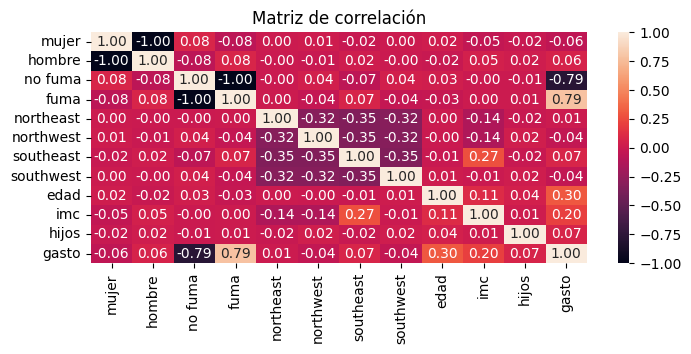

In [996]:
# grafico matriz de correlación
matriz_corr = df_ordenado.corr()
plt.subplots(figsize=(8,3))
plt.title('Matriz de correlación')
sns.heatmap(matriz_corr, annot=True, fmt='.2f')

In [997]:
# obtengo variables más relacionadas con 'gasto'
matriz_corr['gasto'].abs().sort_values(ascending=False)

gasto        1.000000
fuma         0.787251
no fuma      0.787251
edad         0.299008
imc          0.198341
southeast    0.073982
hijos        0.067998
hombre       0.057292
mujer        0.057292
southwest    0.043210
northwest    0.039905
northeast    0.006349
Name: gasto, dtype: float64

In [998]:
# obtengo matriz de variables independientes (matriz_x) y dependientes (matriz_y)
matriz_x = matriz_dataframe[:,:11]
matriz_y = matriz_dataframe[:,11]

# separo los datos 80-20 para entrenamiento y validación respectivamente
x_train, x_test, y_train, y_test = train_test_split(matriz_x, matriz_y, test_size=0.2, random_state=0)

# # escalo los valores
# sc = StandardScaler()
# x_train = sc.fit_transform(x_train)
# x_test = sc.transform(x_test)

# entreno al algoritmo de regresión lineal múltiple
lr = LinearRegression() 
lr.fit(x_train, y_train)

# obtengo 'x', 'c', 'm' (y = mx + c)
c = lr.intercept_ # valor de la ordenada al origen
m = lr.coef_ # valores que puede tomar la pendiente
x = df_ordenado.index # valores que pueden tomas las variables independientes

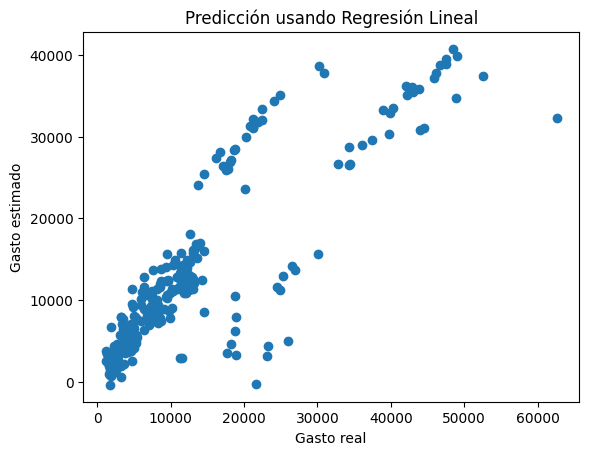

,real,estimado
0,10806.839,12781.821829
1,10264.4421,11076.352126
2,10965.446,11282.169756
3,4433.9159,6597.438476
4,25333.33284,12920.324266


In [999]:
# realizo la predicción
y_pred_test = lr.predict(x_test)

plt.scatter(y_test, y_pred_test)
# plt.plot(y_test, y_pred_test, color = "#20B2AA")
plt.title("Predicción usando Regresión Lineal")
plt.xlabel("Gasto real")
plt.ylabel("Gasto estimado")
plt.show()
# sns.regplot(x=y_test, y=y_pred_test)

# diferencia entre el valor real y el estimado
df_test = pd.DataFrame({'real': y_test, 'estimado': y_pred_test})
df_test.head()


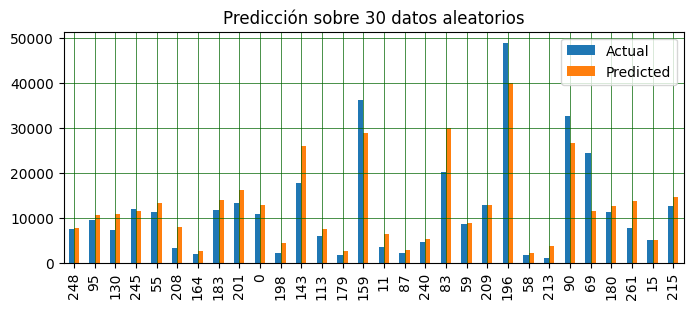

In [1000]:
df_resultados = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_test})
df1 = df_resultados.sample(n = 30)

df1.plot(kind='bar',figsize=(8,3))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='darkgreen')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.title("Predicción sobre 30 datos aleatorios")
plt.show()

In [1001]:
# metricas
print("METRICAS")
print('\nError absoluto mediano:', metrics.median_absolute_error(y_test, y_pred_test))
print('\nError absoluto medio:', metrics.mean_absolute_error(y_test, y_pred_test))
print('\nError cuadrático medio:', metrics.mean_squared_error(y_test, y_pred_test)) 
print('\nRaíz del error cuadrático medio (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, y_pred_test)))
print('\nPromedio de variable independiente (MIV):', df_ordenado["gasto"].mean())

r2 = metrics.r2_score(y_test, y_pred_test)
print('\nr2:', r2)

r2_adj = r2 - (y_test.shape[0] - 1)/(y_test.shape[0] - 2 - 1) * (1 - r2)
print('\nr2 ajustado:', r2_adj)

# [RMSE > MIV * 0.1] -> [modelo impreciso]
# [RMSE < MIV * 0.1] -> [modelo preciso]

METRICAS

Error absoluto mediano: 2183.1167409161408

Error absoluto medio: 4103.738375866689

Error cuadrático medio: 38190055.88954913

Raíz del error cuadrático medio (RMSE): 6179.810344140759

Promedio de variable independiente (MIV): 13270.422265141267

r2: 0.753879159659775

r2 ajustado: 0.5059008035433974
